## Example 1 – Problem Setup 

**Given ODE:**
$$\frac{d\psi}{dx} + \left(x + \frac{1 + 3x^2}{1 + x + x^3} \right)\psi = x^3 + 2x + x^2 \cdot \frac{1 + 3x^2}{1 + x + x^3}$$

**Initial Condition:**
$$\psi(0) = 1$$

**Domain:**
$$x \in [0, 1]$$

**Goal:**
We want to approximate the function $\psi(x)$ using a neural network.

## Step 1: Define the Trial Solution

We follow the idea from the paper:

$$\psi_t(x) = 1 + x \cdot N(x)$$

This **automatically satisfies** the initial condition:

* At $x = 0$, we get $\psi_t(0) = 1 + 0 \cdot N(0) = 1$ 

### Explanation:

* The value `1` is fixed (matches the IC).
* The network part `x · N(x)` is **0 at x=0**, so doesn't affect the boundary.

## Step 2: Neural Network N(x)

We'll define a **simple feedforward neural network**:

### Architecture:
* **Input:** scalar $x$
* **Hidden Layer:** 10 neurons (with sigmoid activation)
* **Output Layer:** 1 neuron (linear activation)

So mathematically:
$$N(x) = \sum_{j=1}^{10} w_{2j} \cdot \sigma(w_{1j}x + b_{1j}) + b_2$$

### Activation Function
We'll use the **sigmoid function**:
$$\sigma(z) = \frac{1}{1 + e^{-z}}, \quad \sigma'(z) = \sigma(z)(1 - \sigma(z))$$

In [1]:
import numpy as np

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z):
    s = sigmoid(z)
    return s * (1 - s)

In [3]:
# Neural network with 1 hidden layer
class NeuralNet:
    def __init__(self, n_hidden = 20):
        self.n_hidden = n_hidden
        self.w1 = np.random.randn(n_hidden)   
        self.b1 = np.random.randn(n_hidden)    
        self.w2 = np.random.randn(n_hidden)    
        self.b2 = np.random.randn(1)[0]        

    def forward(self, x):
        z = x @ self.w1.reshape(1, -1) + self.b1  
        a = sigmoid(z)                            
        y = a @ self.w2.reshape(-1, 1) + self.b2 
        return y

    def derivative(self, x):
        z = x @ self.w1.reshape(1, -1) + self.b1  
        dsig = d_sigmoid(z)                       
        grad = dsig * self.w1                     
        dNdx = grad @ self.w2.reshape(-1, 1)      
        return dNdx

We have a functional neural network $N(x)$, that can compute:
* The **value**: $N(x)$
* The **derivative**: $\frac{dN(x)}{dx}$

And we are ready to construct the **trial solution**:

$$\psi_t(x) = 1 + x \cdot N(x)$$

And its derivative:

$$\frac{d\psi_t}{dx} = N(x) + x \cdot \frac{dN(x)}{dx}$$

# Construct the **Residual and Loss Function**

We now build the core training logic: We compute how far the **trial solution** $\psi_t(x) = 1 + x \cdot N(x)$ is from satisfying the ODE:

## ODE from the Paper

$$\frac{d\psi}{dx} + \left(x + \frac{1 + 3x^2}{1 + x + x^3} \right)\psi = x^3 + 2x + x^2 \cdot \frac{1 + 3x^2}{1 + x + x^3}$$

We write this in the general form:

$$\frac{d\psi}{dx} = f(x, \psi)$$

Where:

$$f(x, \psi) = x^3 + 2x + x^2 \cdot \frac{1 + 3x^2}{1 + x + x^3} - \left(x + \frac{1 + 3x^2}{1 + x + x^3} \right)\cdot \psi$$

In [4]:
def ode_rhs(x, psi):
    x = x.reshape(-1, 1)
    term = (1 + 3 * x**2) / (1 + x +
                             x**3)
    return x**3 + 2 * x + x**2 * term - (x + term) * psi

This defines the **right-hand side of the ODE**, which we are trying to solve

In [5]:
# Trial solution
def psi_trial(x, net):
    
    return 1 + x * net.forward(x)

This defines the **trial solution to the ODE.**

In [6]:
# Derivative of trial solution
def d_psi_trial(x, net):
    return net.forward(x) + x * net.derivative(x)

This uses the **product rule** to compute the derivative of the trial solution:

$$\psi_{\text{trial}}(x) = 1 + x \cdot N(x) \Rightarrow \frac{d\psi_{\text{trial}}}{dx} = N(x) + x \cdot \frac{dN}{dx}$$

Where:
* `net.forward(x)` gives $N(x)$
* `net.derivative(x)` gives $\frac{dN}{dx}$

In [7]:
def residual(x, net):
    psi = psi_trial(x, net)
    dpsi = d_psi_trial(x, net)
    return dpsi - ode_rhs(x, psi)

This calculates the **ODE residual**, i.e., the error between the LHS and RHS of the ODE

In [8]:
# Loss function: mean squared residual error
def loss_fn(x, net):
    res = residual(x, net)
    return np.mean(res**2)

In [9]:
x_train = np.linspace(0, 1, 10).reshape(-1, 1)
# Create neural network
nn = NeuralNet(n_hidden=10)

In [10]:
print("Initial loss:", loss_fn(x_train, nn))

Initial loss: 27.392228393822116


# Step 4: Train the Neural Network Using Optimization (BFGS)

We will **minimize the loss function** using `scipy.optimize.minimize`, specifically using the **BFGS** algorithm

In [11]:
def pack_params(net):
    return np.concatenate([
        net.w1.flatten(),
        net.b1.flatten(),
        net.w2.flatten(),
        np.array([net.b2])
    ])

- Takes all the neural network's parameters and flattens them into a single 1D NumPy array.
- This is required for optimizers that work with flat arrays rather than structured data.

In [12]:
def unpack_params(net, params):
    n = net.n_hidden
    net.w1 = params[0:n]
    net.b1 = params[n:2*n]
    net.w2 = params[2*n:3*n]
    net.b2 = params[3*n]

Slices the 1D array params and assigns:

- First n values to w1
- Next n values to b1
- Next n values to w2
- Final value to b2

#### **Define the Objective Function**

In [13]:
def objective(params, net, x_train):
    unpack_params(net, params)
    return loss_fn(x_train, net)

#### **Optimize with scipy.optimize.minimize**

In [14]:
from scipy.optimize import minimize

# Training points (collocation)
x_train = np.linspace(0, 1, 10).reshape(-1, 1)

In [15]:
# Initialize network
net = NeuralNet(n_hidden=20)
params0 = pack_params(net)

In [16]:
# Optimize using BFGS
result = minimize(objective, params0, args=(net, x_train), method='BFGS', options={'disp': True, 'maxiter': 1000})

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 61
         Function evaluations: 4154
         Gradient evaluations: 67


In [17]:
# Update network with optimized weights
unpack_params(net, result.x)

In [18]:
print("\nFinal loss after training:", loss_fn(x_train, net))


Final loss after training: 3.1780621880394393e-06


# **Step 5: Evaluate and Plot the Neural Network Solution vs Analytical Solution**

## Exact Solution (from the paper):

$$\psi(x) = \frac{e^{-x^2 / 2}}{1 + x + x^3} + x^2$$

We'll compare this **ground truth** with the solution from our **trained ANN**, which is:

$$\psi_t(x) = 1 + x \cdot N(x)$$

In [19]:
import matplotlib.pyplot as plt

#### **Exact Solution**

In [20]:
def exact_solution(x):
    return np.exp(-x**2 / 2) / (1 + x + x**3) + x**2

#### **Generate test points**

In [21]:
x_test = np.linspace(0, 1.2, 200).reshape(-1, 1)
psi_ann = psi_trial(x_test, net).flatten()
psi_exact = exact_solution(x_test).flatten()

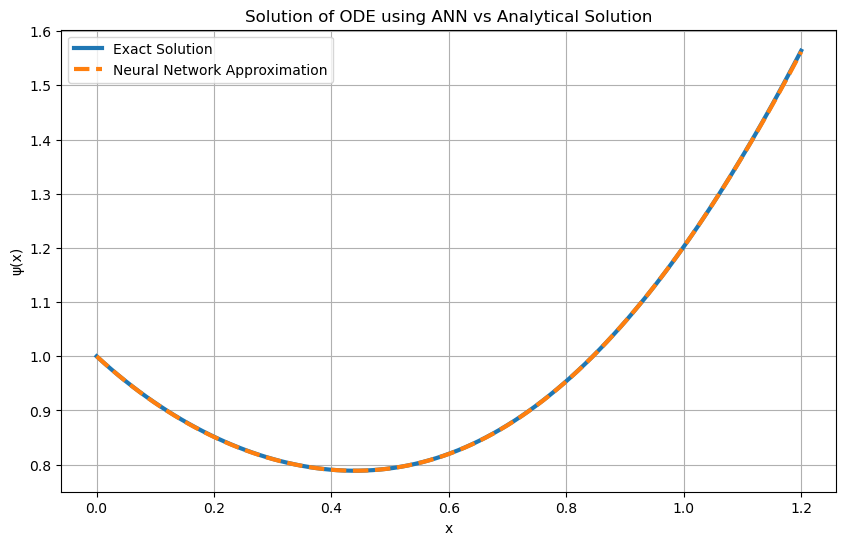

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(x_test, psi_exact, label='Exact Solution', linewidth=3)
plt.plot(x_test, psi_ann, '--', label='Neural Network Approximation', linewidth=3)
plt.xlabel('x')
plt.ylabel('ψ(x)')
plt.title('Solution of ODE using ANN vs Analytical Solution')
plt.grid(True)
plt.legend()
plt.savefig("problem1_ann_vs_exact.png", dpi=300)

plt.show()

# Problem 2 

## Given ODE:

$$\frac{d\Psi}{dx} + \frac{1}{5} \Psi = e^{-x/5} \cos(x)$$

## Initial Condition:

$$\Psi(0) = 0$$

## Exact Solution (as given in the paper):

$$\Psi(x) = e^{-x/5} \sin(x)$$

## Step 1: Trial Solution

Since $\Psi(0) = 0$, we define:

$$\Psi_t(x) = x \cdot N(x)$$

## Step 2: Build Neural Network

In [23]:
import numpy as np

def sigmoid(x): return 1 / (1 + np.exp(-x))
def d_sigmoid(x): s = sigmoid(x); return s * (1 - s)

class NeuralNet:
    def __init__(self, n_hidden=10):
        self.n_hidden = n_hidden
        self.w1 = np.random.randn(n_hidden)
        self.b1 = np.random.randn(n_hidden)
        self.w2 = np.random.randn(n_hidden)
        self.b2 = np.random.randn(1)[0]

    def forward(self, x):
        z = x @ self.w1.reshape(1, -1) + self.b1
        a = sigmoid(z)
        return a @ self.w2.reshape(-1, 1) + self.b2

    def derivative(self, x):
        z = x @ self.w1.reshape(1, -1) + self.b1
        da_dx = d_sigmoid(z) * self.w1
        return da_dx @ self.w2.reshape(-1, 1)

## Step 3: Trial Solution & Derivative

In [24]:
def psi_trial(x, net):
    return x * net.forward(x)

def d_psi_trial(x, net):
    return net.forward(x) + x * net.derivative(x)

## Step 4: Define ODE Residual and Loss

$$\text{Residual} = \frac{d\Psi_t}{dx} + \frac{1}{5} \Psi_t - e^{-x/5} \cos(x)$$

In [25]:
def ode_rhs(x):
    return np.exp(-x / 5) * np.cos(x)

In [26]:
def residual(x, net):
    psi = psi_trial(x, net)
    dpsi = d_psi_trial(x, net)
    return dpsi + (1/5) * psi - ode_rhs(x)

In [27]:
def loss_fn(x, net):
    return np.mean(residual(x, net)**2)

## Step 5: Optimization

In [28]:
def pack_params(net):
    return np.concatenate([net.w1, net.b1, net.w2, np.array([net.b2])])

def unpack_params(net, params):
    n = net.n_hidden
    net.w1 = params[:n]
    net.b1 = params[n:2*n]
    net.w2 = params[2*n:3*n]
    net.b2 = params[3*n]

def objective(params, net, x_train):
    unpack_params(net, params)
    return loss_fn(x_train, net)

In [29]:
x_train = np.linspace(0, np.pi, 50).reshape(-1, 1) 
net = NeuralNet(n_hidden=10)
params0 = pack_params(net)

In [30]:
res = minimize(objective, params0, args=(net, x_train),
               method='BFGS', options={'disp': True, 'maxiter': 3000})
unpack_params(net, res.x)
print("Final Loss:", loss_fn(x_train, net))

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 206
         Function evaluations: 7584
         Gradient evaluations: 237
Final Loss: 5.287538671428919e-07


In [31]:
def exact_solution(x):
    return np.exp(-x / 5) * np.sin(x)

x_test = np.linspace(0, np.pi, 200).reshape(-1, 1)
psi_pred = psi_trial(x_test, net).flatten()
psi_true = exact_solution(x_test).flatten()

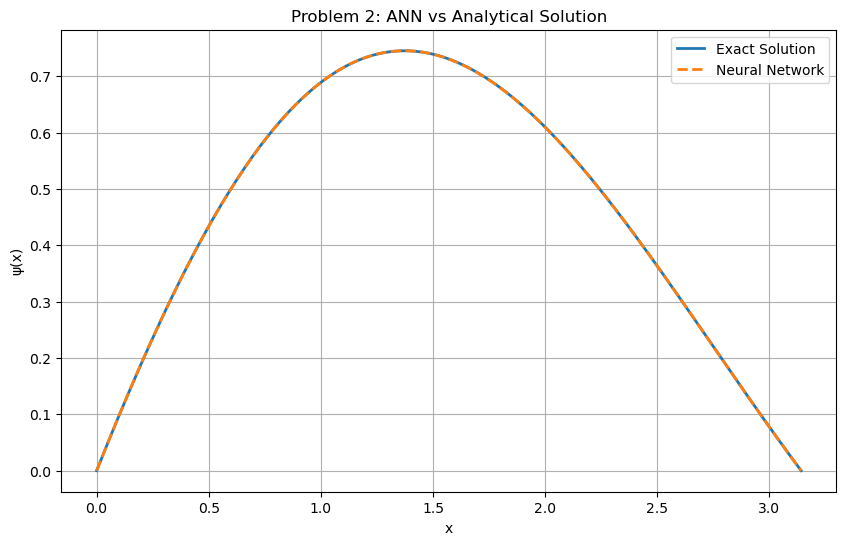

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(x_test, psi_true, label='Exact Solution', linewidth=2)
plt.plot(x_test, psi_pred, '--', label='Neural Network', linewidth=2)
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title("Problem 2: ANN vs Analytical Solution")
plt.grid(True)
plt.legend()
plt.show()

# Problem 3 

## Given ODE:

$$\frac{d^2\Psi}{dx^2} + \frac{1}{5} \frac{d\Psi}{dx} + \Psi = -\frac{1}{5} e^{-x/5} \cos(x)$$

## Initial Conditions:

$$\Psi(0) = 0, \quad \frac{d\Psi}{dx}(0) = 1$$

## Exact Solution:

$$\Psi(x) = e^{-x/5} \sin(x)$$

## Step 1: Trial Solution

We want:
* $\Psi(0) = 0$
* $\Psi'(0) = 1$

Use this trial solution from the paper:

$$\Psi_t(x) = x + x^2 \cdot N(x)$$

## Step 2: Build Neural Network 𝑁(𝑥)

In [33]:
class NeuralNet:
    def __init__(self, n_hidden=10):
        self.n_hidden = n_hidden
        self.w1 = np.random.randn(n_hidden)
        self.b1 = np.random.randn(n_hidden)
        self.w2 = np.random.randn(n_hidden)
        self.b2 = np.random.randn(1)[0]

    def forward(self, x):
        z = x @ self.w1.reshape(1, -1) + self.b1
        a = sigmoid(z)
        return a @ self.w2.reshape(-1, 1) + self.b2

    def derivative(self, x):
        z = x @ self.w1.reshape(1, -1) + self.b1
        dz_dx = d_sigmoid(z) * self.w1
        return dz_dx @ self.w2.reshape(-1, 1)

    def second_derivative(self, x):
        z = x @ self.w1.reshape(1, -1) + self.b1
        s = sigmoid(z)
        d2z_dx2 = d_sigmoid(z) * (1 - 2 * s) * self.w1**2
        return d2z_dx2 @ self.w2.reshape(-1, 1)

## Step 3: Trial Solution and Derivatives

$$\Psi_t(x) = x + x^2 N(x)$$

$$\Psi_t'(x) = 1 + 2xN(x) + x^2 N'(x)$$

$$\Psi_t''(x) = 2N(x) + 4xN'(x) + x^2 N''(x)$$

In [34]:
def psi_trial(x, net):
    return x + x**2 * net.forward(x)

In [35]:
def d_psi_trial(x, net):
    return 1 + 2 * x * net.forward(x) + x**2 * net.derivative(x)

In [36]:
def d2_psi_trial(x, net):
    return 2 * net.forward(x) + 4 * x * net.derivative(x) + x**2 * net.second_derivative(x)

## Step 4: Define the ODE Residual and Loss

The ODE is:

$$\Psi''(x) + \frac{1}{5} \Psi'(x) + \Psi(x) = -\frac{1}{5} e^{-x/5} \cos(x)$$

So residual:

$$R(x) = \Psi_t''(x) + \frac{1}{5} \Psi_t'(x) + \Psi_t(x) + \frac{1}{5} e^{-x/5} \cos(x)$$

In [37]:
def ode_rhs(x):
    return - (1/5) * np.exp(-x / 5) * np.cos(x)

In [38]:
def residual(x, net):
    psi = psi_trial(x, net)
    dpsi = d_psi_trial(x, net)
    d2psi = d2_psi_trial(x, net)
    return d2psi + (1/5) * dpsi + psi - ode_rhs(x)

In [39]:
def loss_fn(x, net):
    return np.mean(residual(x, net)**2)

## Step 5: Optimization and Plot

In [40]:
def pack_params(net):
    return np.concatenate([net.w1, net.b1, net.w2, [net.b2]])

def unpack_params(net, params):
    n = net.n_hidden
    net.w1 = params[:n]
    net.b1 = params[n:2*n]
    net.w2 = params[2*n:3*n]
    net.b2 = params[3*n]

def objective(params, net, x_train):
    unpack_params(net, params)
    return loss_fn(x_train, net)

In [41]:
x_train = np.linspace(0, np.pi, 50).reshape(-1, 1)

In [42]:
net = NeuralNet(n_hidden=10)
params0 = pack_params(net)

In [43]:
res = minimize(objective, params0, args=(net, x_train),
               method='BFGS', options={'disp': True, 'maxiter': 1000})
unpack_params(net, res.x)
print("Final Loss:", loss_fn(x_train, net))

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 73
         Function evaluations: 2592
         Gradient evaluations: 81
Final Loss: 5.547622086612796e-07


**Exact Solution**

In [44]:
def exact_solution(x):
    return np.exp(-x / 5) * np.sin(x)

In [45]:
x_test = np.linspace(0, np.pi, 200).reshape(-1, 1)
psi_pred = psi_trial(x_test, net).flatten()
psi_true = exact_solution(x_test).flatten()

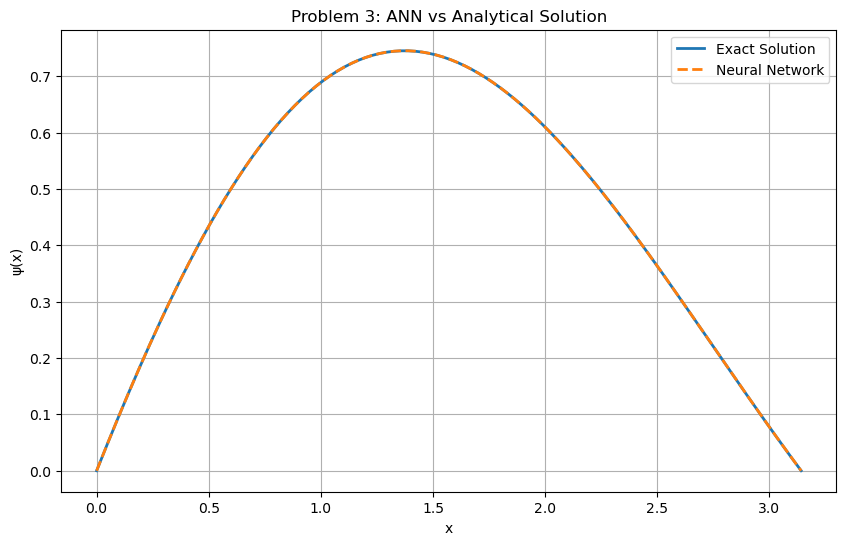

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(x_test, psi_true, label='Exact Solution', linewidth=2)
plt.plot(x_test, psi_pred, '--', label='Neural Network', linewidth=2)
plt.xlabel('x')
plt.ylabel('ψ(x)')
plt.title('Problem 3: ANN vs Analytical Solution')
plt.grid(True)
plt.legend()
plt.show()